In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_v, n_clust_obs_f_v_val
from src.python.visualization import perf_tester_over_obs

import numpy as np
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [6]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [7]:
# Cosine Decay with Restarts

initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.8
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
#trial_folder = 'checkpoints_var_obs'
#checkpoint_path = os.path.join(os.getcwd(), trial_folder)
checkpoint_path = 'C:\\Users\\lasse\\Documents\\hierarchical model comparison project\\checkpoints\\checkpoints_var_obs'

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    checkpoint_path=checkpoint_path,
    max_to_keep=1,
    skip_checks=True
    )

Networks loaded from C:\Users\lasse\Documents\hierarchical model comparison project\checkpoints\checkpoints_var_obs\ckpt-20


In [8]:
n_obs_min = 1 
n_obs_max = 100

# Train & validate

In [5]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=20, iterations_per_epoch=1000, batch_size=32, 
    n_obs=partial(n_clust_obs_f_v, n_obs_min, n_obs_max)
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# Validation

# Generate data for each setting
n_val_per_setting = 5000

m_val = []
x_val = []

for n in range(n_obs_min, n_obs_max+1):
    m_val_sim, _, x_val_sim = simulator(n_val_per_setting, n_clust_obs_f_v_val(n))
    m_val.append(m_val_sim)
    x_val.append(x_val_sim)
    if n%25 == 0:
        print('Iteration {} finished'.format(n))

val_data = {'X' : x_val, 'm' : m_val}

Iteration 25 finished
Iteration 50 finished
Iteration 75 finished
Iteration 100 finished


Mean ECE = 0.04918406829607203


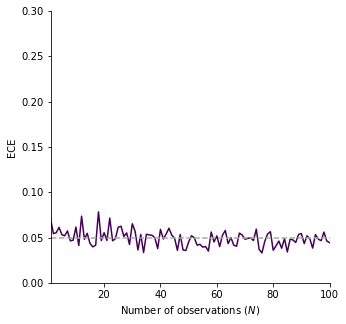

In [10]:
# Plot validation results publication-ready
save_fig = True

perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, pub_style=True, save=save_fig)

Mean ECE = 0.04876184466365501


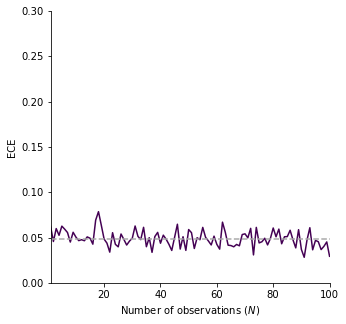

In [7]:
# Plot validation results publication-ready
save_fig = True

perf_tester_over_obs(evidence_net, summary_net, val_data, n_obs_min, n_obs_max, pub_style=True, save=save_fig)

# For publication: Plot together with calibration curve from calibration experiment 1

In [3]:
# load network from calibration experiment 1

summary_net_1 = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net_1 = EvidentialNetwork(evidence_meta_validation)

amortizer_1 = MultiModelAmortizer(evidence_net_1, summary_net_1)

simulator_1 = MainSimulator(HierarchicalNormalSimulator())

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'checkpoints_fixed'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer_1, 
    checkpoint_path=checkpoint_path,
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\01_calibration_validation\checkpoints_fixed\ckpt-10


ECE = 0.041


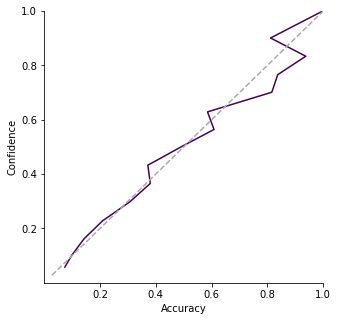

In [5]:
from src.python.helpers import n_clust_obs_f_f
from src.python.visualization import perf_tester

n_val_1 = 5000
m_val_1, _, x_val_1 = simulator_1(n_val_1, n_clust_obs_f_f())
val_data_1 = {'X' : x_val_1, 'm' : m_val_1}

perf_tester(evidence_net_1, summary_net_1, val_data_1, n_cal_bins=15, pub_style=True)

In [ ]:
import matplotlib as plt
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

# TODO: embed both figures into one subplot